# Семантическая сегментация дорожных сцен.

* Используемый датасет "CityScapes" - https://www.cityscapes-dataset.com/downloads/
* Архитерктура модели "U-Net"

In [1]:
# Import needs libraries
from UNetModel import UNetModel

import os
from PIL import Image

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [2]:
# Setup agnostic-code cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Download CityScapes dataset from `torchvision.datasets`

In [3]:
os.getcwd()

'/home/evgeny/PycharmProjects/2D_SemSeg_VKR'

In [4]:
data_path = '/media/evgeny/6610D40610D3DB5F/Download_Softwares/PyCharm/Projects/2D_SemSeg_VKR/Datasets/CityScapes'

In [5]:
train_data = datasets.Cityscapes(root=data_path,
                                 split="train",
                                 mode="fine",
                                 target_type="semantic",
#                                  transform=transforms.ToTensor(),
                                 target_transform=None)
train_data

Dataset Cityscapes
    Number of datapoints: 2975
    Root location: /media/evgeny/6610D40610D3DB5F/Download_Softwares/PyCharm/Projects/2D_SemSeg_VKR/Datasets/CityScapes
    Split: train
    Mode: gtFine
    Type: ['semantic']

In [6]:
train_data[0]

(<PIL.Image.Image image mode=RGB size=2048x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>)

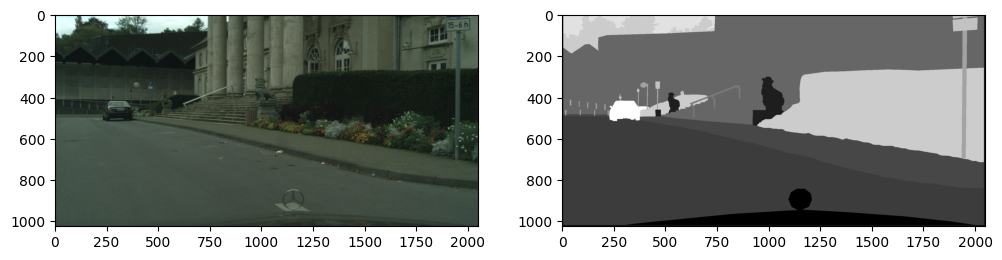

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
ax[0].imshow(train_data[0][0])
ax[1].imshow(train_data[0][1], cmap='gray')

In [8]:
a = np.array(train_data[0][1].convert("RGB"))
np.unique(a)

array([ 1,  3,  4,  7,  8, 11, 13, 17, 20, 21, 23, 26], dtype=uint8)

### Some utils functions

https://github.com/meetps/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py

In [9]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = [ "unlabelled", "road", "sidewalk", "building", "wall", "fence", "pole", "traffic_light", 
               "traffic_sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", 
               "train", "motorcycle", "bicycle"]

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes = len(valid_classes)
print(f"len(n_classes): {n_classes}\n")
print(class_map)

len(n_classes): 20

{255: 0, 7: 1, 8: 2, 11: 3, 12: 4, 13: 5, 17: 6, 19: 7, 20: 8, 21: 9, 22: 10, 23: 11, 24: 12, 25: 13, 26: 14, 27: 15, 28: 16, 31: 17, 32: 18, 33: 19}


In [10]:
colors = [[  0,   0,   0],
          [128, 64, 128],
          [244, 35, 232],
          [70, 70, 70],
          [102, 102, 156],
          [190, 153, 153],
          [153, 153, 153],
          [250, 170, 30],
          [220, 220, 0],
          [107, 142, 35],
          [152, 251, 152],
          [0, 130, 180],
          [220, 20, 60],
          [255, 0, 0],
          [0, 0, 142],
          [0, 0, 70],
          [0, 60, 100],
          [0, 80, 100],
          [0, 0, 230],
          [119, 11, 32],
        ]

label_colors = dict(zip(range(n_classes), colors))
label_colors

{0: [0, 0, 0],
 1: [128, 64, 128],
 2: [244, 35, 232],
 3: [70, 70, 70],
 4: [102, 102, 156],
 5: [190, 153, 153],
 6: [153, 153, 153],
 7: [250, 170, 30],
 8: [220, 220, 0],
 9: [107, 142, 35],
 10: [152, 251, 152],
 11: [0, 130, 180],
 12: [220, 20, 60],
 13: [255, 0, 0],
 14: [0, 0, 142],
 15: [0, 0, 70],
 16: [0, 60, 100],
 17: [0, 80, 100],
 18: [0, 0, 230],
 19: [119, 11, 32]}

In [11]:
def encode_segmap(mask):
    """
    Переназначаем все нежелательные классы на ignore_index (255)
    а Желательные классы переопределяем на новые значения индексов
    """
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

def decode_segmap(temp):
    # Преобразуем серое изображение в цветное RGB
    temp = temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    
    for i in range(0, n_classes):
        r[temp == i] = label_colors[i][0]
        g[temp == i] = label_colors[i][1]
        b[temp == i] = label_colors[i][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [210]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_A = A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


In [208]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from torchvision.datasets import Cityscapes

class MyClassCityscapes(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types if target_type is a list with more
            than one item. Otherwise, target is a json object if target_type="polygon", else the image segmentation.
        """

        image = Image.open(self.images[index]).convert("RGB")

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == "polygon":
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])

            targets.append(target)

        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed = transform_A(image=np.array(image), mask=np.array(target))
            
        return transformed['image'], transformed['mask']

In [209]:
new_train_data = MyClassCityscapes(root=data_path,
                                 split="train",
                                 mode="fine",
                                 target_type="semantic",
                                 transforms=transform_A,
                                 target_transform=None)

img, seg = new_train_data[10]
print(img.shape, seg.shape)

torch.Size([3, 512, 512]) torch.Size([512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


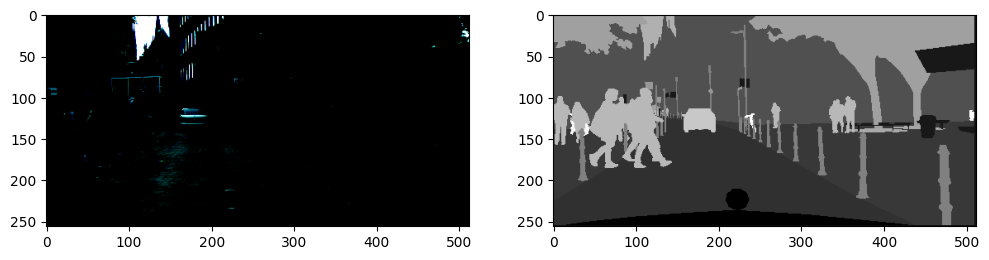

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(seg, cmap='gray')

In [16]:
# class labels before label correction
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  3,  4,  7,  8, 11, 17, 20, 21, 22, 23, 24, 26, 32, 33],
       dtype=torch.uint8)
15


In [17]:
# class labels after label correction
result = encode_segmap(seg.clone())
print(f"result shape: {result.shape}")
print(f"torch unique (result) : {torch.unique(result)}")
print(f"length: {len(torch.unique(result))}")

result shape: torch.Size([256, 512])
torch unique (result) : tensor([ 0,  1,  2,  3,  6,  8,  9, 10, 11, 12, 14, 18, 19], dtype=torch.uint8)
length: 13


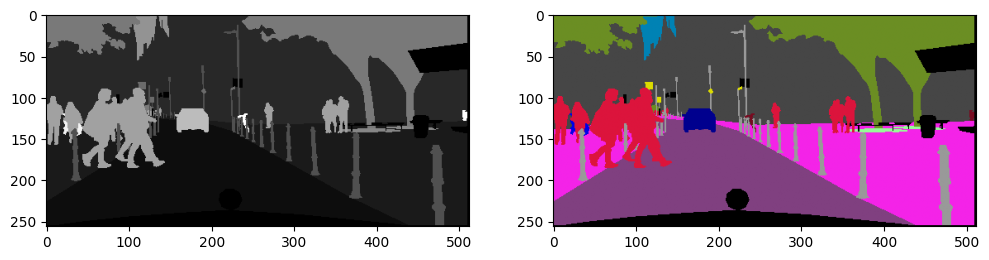

In [18]:
# let's add color in sem seg
result1 = decode_segmap(result.clone())

fig, ax = plt.subplots(ncols=2, figsize=(12,8))
ax[0].imshow(result, cmap='gray')
ax[1].imshow(result1)

### Dataloader

In [19]:
new_val_data = MyClassCityscapes(root=data_path,
                                 split="val",
                                 mode="fine",
                                 target_type="semantic",
                                 transforms=transform_A,
                                 target_transform=None)

new_train_data, new_val_data

(Dataset MyClassCityscapes
     Number of datapoints: 2975
     Root location: /media/evgeny/6610D40610D3DB5F/Download_Softwares/PyCharm/Projects/2D_SemSeg_VKR/Datasets/CityScapes
     Split: train
     Mode: gtFine
     Type: ['semantic']
     Compose([
   Resize(always_apply=False, p=1, height=256, width=512, interpolation=1),
   HorizontalFlip(always_apply=False, p=0.5),
   Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
   ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
 Dataset MyClassCityscapes
     Number of datapoints: 500
     Root location: /media/evgeny/6610D40610D3DB5F/Download_Softwares/PyCharm/Projects/2D_SemSeg_VKR/Datasets/CityScapes
     Split: val
     Mode: gtFine
     Type: ['semantic']
     Compose([
   Resize(always_apply=False, p=1, height=256, width=512, interpolation=1),
   HorizontalFlip(always_apply=False, 

In [20]:
# Set a hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 16

# Set a parametrs
epochs = 3
n_classes = n_classes

In [21]:
train_dataloader = DataLoader(dataset=new_train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

val_dataloader = DataLoader(dataset=new_val_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f4698379d90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4698379520>)

In [22]:
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of val_dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}...")

Length of train_dataloader: 186 batches of 16...
Length of val_dataloader: 32 batches of 16...


In [23]:
batch, label = next(iter(train_dataloader))
batch.shape, label.shape

(torch.Size([16, 3, 256, 512]), torch.Size([16, 256, 512]))

In [24]:
for Batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {Batch}")
    print(f"X: {X.shape}")
    print(f"y: {y.shape}")
    break

Batch: 0
X: torch.Size([16, 3, 256, 512])
y: torch.Size([16, 256, 512])


## 2. Create Model

In [25]:
import torchmetrics

In [110]:
ModelV1 = UNetModel(input_channels=3,
                        output_classes=n_classes,
                        up_sample_mode='bilinear',
                        up_sample_align_corner=False,
                        padding=1,
                        stride=1,
                        kernel=3,
                        number_conv_layers=2,
                        ).to(device)
ModelV1

UNetModel(
  (input_layer): ConvBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_block_1): Down(
    (maxpool_conv_block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

### Setup optimizer and loss function

In [66]:
optimizer = torch.optim.AdamW(params=ModelV1.parameters(),
                             lr=LEARNING_RATE)

loss_fn = nn.CrossEntropyLoss()
# metric = torchmetrics.

NameError: name 'ModelV1' is not defined

## 3. Train Model

### Training Loop

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)

# Training loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} from {epochs}\n------------------")
    
    train_loss, val_loss = 0.0, 0.0
    ModelV1.train()
    
    # Add a loop through the training batches
    for batch, (img, seg) in enumerate(train_dataloader):
        #Put data on the target device
        img, seg = img.to(device), seg.to(device)
        
        # Output logits ModelV1
        y_pred = ModelV1(img)
        # Encode mask
        seg = encode_segmap(seg)
        # Calculate Loss
        loss = loss_fn(y_pred, seg.long())
        metric = ...
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)
    print(f"Train loss: {train_loss:.4f}")
    
    ModelV1.eval()
    
    # Add a loop through the val batches
    with torch.inference_mode():
        for batch, (img, seg) in enumerate(val_dataloader):
            #Put data on the target device
            img, seg = img.to(device), seg.to(device)
            
            # Output logits ModelV1
            val_pred = ModelV1(img)
            # Encode mask
            seg = encode_segmap(seg)
            # Calculate Loss
            loss = loss_fn(val_pred, seg.long())
            metric = ...
            val_loss += loss
            
        val_loss /= len(val_dataloader)
        print(f"Val loss: {val_loss:.4f}")

### Test Loop

## 4. Evaluate Model

In [111]:
new_test_data = MyClassCityscapes(root=data_path,
                                 split="val",
                                 mode="fine",
                                 target_type="semantic",
                                 transforms=transform_A,
                                 target_transform=None)


test_dataloader = DataLoader(dataset=new_test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)
test_dataloader

In [112]:
from time import time

start = time()

ModelV1.eval()
with torch.inference_mode():
    for batch in test_dataloader:
        img, seg = batch
        output = ModelV1(img)
        break

print(time()-start)
print(img.shape, seg.shape, output.shape)

12.769136428833008
torch.Size([16, 3, 256, 512]) torch.Size([16, 256, 512]) torch.Size([16, 19, 256, 512])


In [45]:
from time import time

start = time()

seg_model.eval()
with torch.inference_mode():
    for batch in test_dataloader:
        img, seg = batch
        output = seg_model(img)
        break

print(time()-start)
print(img.shape, seg.shape, output.logits.shape)

6.917629718780518
torch.Size([16, 3, 256, 512]) torch.Size([16, 256, 512]) torch.Size([16, 19, 64, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


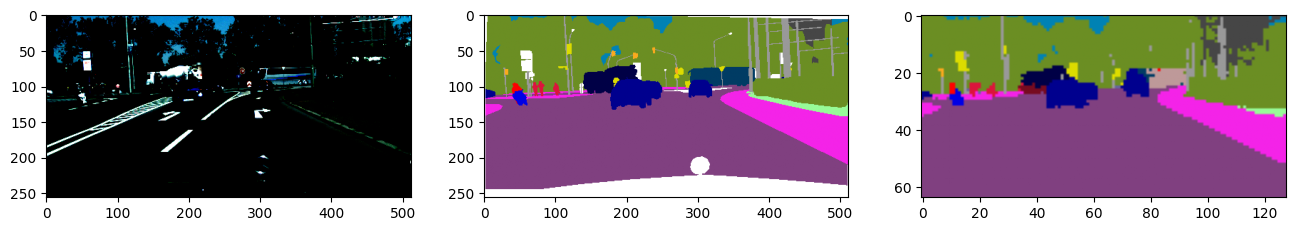

In [59]:
sample = 4

outputx = output.detach().cpu()[sample]
encoded_mask = encode_segmap(seg[sample].clone())
decoded_mask = decode_segmap(encoded_mask.clone())

# print(f"outputx.shape: {outputx.shape}")
# print(f"torch.argmax(outputx, dim=0): {torch.argmax(outputx, dim=0).shape}")
decoded_outputx = decode_segmap(torch.argmax(outputx, dim=0))
# print("decoded_outputx.shape:",decoded_outputx.shape)

fig, ax = plt.subplots(ncols=3, figsize=(16,12))
ax[0].imshow(np.moveaxis(img[sample].numpy(), 0, 2))
ax[1].imshow(decoded_mask)
ax[2].imshow(decoded_outputx)

## 5. Save model state dict

In [ ]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "Cityscapes_ModelV1_2xConvBlock.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=ModelV1.state_dict(),
           f=MODEL_SAVE_PATH)

In [26]:
# Create a new instance
torch.manual_seed(42)
Model_Save_Path = "/media/evgeny/6610D40610D3DB5F/Download_Softwares/PyCharm/Projects/2D_SemSeg_VKR/models/Cityscapes_ModelV1_2xConvBlock.pth"

loaded_model = UNetModel(input_channels=3,
                        output_classes=n_classes,
                        up_sample_mode='bilinear',
                        up_sample_align_corner=False,
                        padding=1,
                        stride=1,
                        kernel=3,
                        number_conv_layers=2,
                        )

# Load in the save state_dict()
loaded_model.load_state_dict(torch.load(f=Model_Save_Path))

# Send the model to the target device
loaded_model.to('cpu')
loaded_model

UNetModel(
  (input_layer): ConvBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_block_1): Down(
    (maxpool_conv_block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

# SegFormer Pretrained Model

In [33]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

pretrained_weights = "/media/evgeny/6610D40610D3DB5F/Download_Softwares/PyCharm/Projects/2D_SemSeg_VKR/models/segformer.b5.1024x1024.city.160k.pth"

image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b4-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-cityscapes-1024-1024")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
list(logits.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/evgeny/PycharmProjects/2D_SemSeg_VKR/venv/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


[1, 19, 128, 128]

In [34]:
print(inputs['pixel_values'].shape)
print(torch.unique(torch.round(logits)))

torch.Size([1, 3, 512, 512])
tensor([-35., -34., -33., -32., -31., -30., -29., -28., -27., -26., -25., -24.,
        -23., -22., -21., -20., -19., -18., -17., -16., -15., -14., -13., -12.,
        -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,  -0.,
          1.,   2.,   3.,   4.], grad_fn=<Unique2Backward0>)


## Load data and setup classes and color maps

In [57]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = [ "road", "sidewalk", "building", "wall", "fence", "pole", "traffic_light", 
               "traffic_sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", 
               "train", "motorcycle", "bicycle"]

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes = len(valid_classes)
print(f"len(n_classes): {n_classes}\n")
print(class_map)

len(n_classes): 19

{7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18}


In [58]:
colors = [[128, 64, 128],
          [244, 35, 232],
          [70, 70, 70],
          [102, 102, 156],
          [190, 153, 153],
          [153, 153, 153],
          [250, 170, 30],
          [220, 220, 0],
          [107, 142, 35],
          [152, 251, 152],
          [0, 130, 180],
          [220, 20, 60],
          [255, 0, 0],
          [0, 0, 142],
          [0, 0, 70],
          [0, 60, 100],
          [0, 80, 100],
          [0, 0, 230],
          [119, 11, 32],
        ]

label_colors = dict(zip(range(n_classes), colors))
label_colors

{0: [128, 64, 128],
 1: [244, 35, 232],
 2: [70, 70, 70],
 3: [102, 102, 156],
 4: [190, 153, 153],
 5: [153, 153, 153],
 6: [250, 170, 30],
 7: [220, 220, 0],
 8: [107, 142, 35],
 9: [152, 251, 152],
 10: [0, 130, 180],
 11: [220, 20, 60],
 12: [255, 0, 0],
 13: [0, 0, 142],
 14: [0, 0, 70],
 15: [0, 60, 100],
 16: [0, 80, 100],
 17: [0, 0, 230],
 18: [119, 11, 32]}

In [211]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_B = A.Compose(
[
    A.Resize(512, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])
transform_mask = A.Compose(
[
    A.Resize(64, 128),
])

In [164]:
new_val_data = MyClassCityscapes(root=data_path,
                                 split="val",
                                 mode="fine",
                                 target_type="semantic",
                                 transforms=transform_B,
                                 target_transform=None)

val_dataloader = DataLoader(dataset=new_val_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

new_val_data, val_dataloader

(Dataset MyClassCityscapes
     Number of datapoints: 500
     Root location: /media/evgeny/6610D40610D3DB5F/Download_Softwares/PyCharm/Projects/2D_SemSeg_VKR/Datasets/CityScapes
     Split: val
     Mode: gtFine
     Type: ['semantic']
     Compose([
   Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
   HorizontalFlip(always_apply=False, p=0.5),
   Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
   ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
 <torch.utils.data.dataloader.DataLoader at 0x7f465406a9d0>)

## Create seg_model

In [39]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b4-finetuned-cityscapes-1024-1024")
seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-cityscapes-1024-1024")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [196]:
from torch.nn import functional as F
torch.manual_seed(42)
t = torch.randn(size=(2,20,2,2))
a = torch.randn(size=(2,2,2))
c = torch.randn(16, 256,512)
s = c.shape
print(c.shape[1])
c = c.numpy()
c = transform_mask(image=c)
print(c['image'].shape)
# print(t)

print(f"view[-1]: {F.sigmoid(t[:,0]).view(-1).shape}")
print(f"view[-1]: {F.sigmoid(a).view(-1).shape}")

256
(64, 128, 512)
view[-1]: torch.Size([8])
view[-1]: torch.Size([8])


## Loss functions

In [197]:
def resize_masks(masks):
    new_masks = torch.zeros([masks.shape[0], 64, 128])
    for i, im in enumerate(masks):
        np_targets = transform_mask(image=im.numpy())
        seg = torch.tensor(np_targets['image'])
        new_masks[i] = seg

    return new_masks

In [201]:
def dice_loss(logits, targets):
    # Dice similarity coefficient
    smooth = 1e-5
    num_classes = logits.size(1)
    loss = 0.0
#     print(f"Logits.shape: {logits.shape}")
#     print(f"targets.shape: {targets.shape}")
#     print(f"num_classes: {num_classes}")
        
    for i in range(num_classes):
        iflat = logits[:, i].contiguous().view(-1)
        tflat = targets[:].contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        loss += ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    
    return 1.0 - (loss / num_classes)

def jaccard_loss(logits, targets):
    # Jaccard loss
    smooth = 1e-5
    num_classes = logits.size(1)
    loss = 0.0
    
    for i in range(num_classes):
        iflat = logits[:, i].contiguous().view(-1)
        tflat = targets[:].contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        union = (iflat.sum() + tflat.sum()) - intersection
        loss += (intersection + smooth) / (union + smooth)
    
    return 1.0 - (loss / num_classes)

In [202]:
loss_dice = dice_loss
loss_jaccard = jaccard_loss

## Evaluate Seg model

In [203]:
from tqdm.auto import tqdm

torch.manual_seed(42)

# Set a hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 16

# Set a parametrs
epochs = 3
n_classes = n_classes

val_dice_loss = 0.0
val_jaccard_loss = 0.0

indexx = 0

seg_model.eval()
with torch.inference_mode():
    for img, seg in tqdm(val_dataloader, desc='evaluate process...'):
#         img = image_processor(images=image, return_tensors="pt")
        # transform mask in true size
        seg = resize_masks(seg)

        # Output logits Seg_model
        val_pred = seg_model(img)
        # Encode mask
        seg = encode_segmap(seg)
        # Calculate Loss
        val_dice_loss += loss_dice(val_pred.logits, seg.long())
        val_jaccard_loss += loss_jaccard(val_pred.logits, seg.long())

    val_dice_loss /= len(val_dataloader)
    val_jaccard_loss /= len(val_dataloader)
    print(f"Val Dice loss: {val_dice_loss:.4f} | Val Jaccard Loss: {val_jaccard_loss:.4f}")

evaluate process...:   0%|          | 0/32 [00:00<?, ?it/s]

Val Dice loss: 75.1219 | Val Jaccard Loss: 1.9626


In [205]:
from tqdm.auto import tqdm

torch.manual_seed(42)

# Set a hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 16

# Set a parametrs
epochs = 3
n_classes = n_classes

val_dice_loss = 0.0
val_jaccard_loss = 0.0

indexx = 0

seg_model.eval()
with torch.inference_mode():
    for img, seg in tqdm(val_dataloader, desc='evaluate process...'):
#         img = image_processor(images=image, return_tensors="pt")
        # transform mask in true size
        seg = resize_masks(seg)

        # Output logits Seg_model
        val_pred = seg_model(img)
        # Encode mask
        seg = encode_segmap(seg)
        # Calculate Loss
        val_dice_loss += loss_dice(val_pred.logits, seg)
        val_jaccard_loss += loss_jaccard(val_pred.logits, seg)
        break

    val_dice_loss /= 1
    val_jaccard_loss /= 1
    print(f"Val Dice loss: {val_dice_loss:.4f} | Val Jaccard Loss: {val_jaccard_loss:.4f}")

evaluate process...:   0%|          | 0/32 [00:00<?, ?it/s]

Val Dice loss: 58.7980 | Val Jaccard Loss: 1.9591


## Output logits and Vizualise

In [212]:
seg_model.eval()
with torch.inference_mode():
    for img, seg in tqdm(val_dataloader, desc='evaluate process...'):
#         img = image_processor(images=image, return_tensors="pt")
        # transform mask in true size
        seg = resize_masks(seg)

        # Output logits Seg_model
        output = seg_model(img)
        break


evaluate process...:   0%|          | 0/32 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


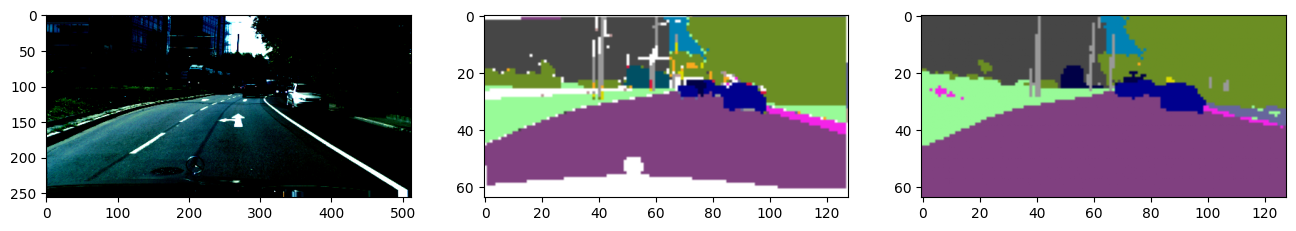

In [214]:
sample = 5

outputx = output.logits.detach().cpu()[sample]
encoded_mask = encode_segmap(seg[sample].clone())
decoded_mask = decode_segmap(encoded_mask.clone())

# print(f"outputx.shape: {outputx.shape}")
# print(f"torch.argmax(outputx, dim=0): {torch.argmax(outputx, dim=0).shape}")
decoded_outputx = decode_segmap(torch.argmax(outputx, dim=0))
# print("decoded_outputx.shape:",decoded_outputx.shape)

fig, ax = plt.subplots(ncols=3, figsize=(16,12))
ax[0].imshow(np.moveaxis(img[sample].numpy(), 0, 2))
ax[1].imshow(decoded_mask)
ax[2].imshow(decoded_outputx)

# UNet with attention